# Import Packages

In [689]:
# Data
import pandas as pd
import geopandas as gpd
import numpy as np

# Package management
import os
import sys
import importlib

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set_style('white')
sns.set_context("paper")

# Progress Bars
from tqdm.notebook import tqdm

import data_processing
importlib.reload(data_processing)
from data_processing import LADVehicleRegistrationDataProcessor

# Trends in London's EV Adoption 

Here, we're interested in tracking the adoption of pure Battery Electric Vehicles (BEVs), that we will refer to interchanably as **"EVs"**. This is because of their sole dependance on charging infrastructure compared to plug-in hybrids that have the option of conventional refuelling.

### Loading EV registration data

Firstly, let's load in a list of london LADs (Boroughs). This will serve as a way of indexing/filtering larger UK-wide datasets.

In [2]:
london_lad_df = pd.read_csv('data/lad_boundaries/London_LAD_List.csv')
london_lad_list = london_lad_df['LAD22NM'].values
print(london_lad_list)
print('\nNumber of London Boroughs: ' + str(len(london_lad_list)))

['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster']

Number of London Boroughs: 33


Next, let's load in the LAD-Level vehicle registration data from the **UK department for transport (DfT)**. 

We'll use a data processor class that I made previously to load-in and clean the data.

In [7]:
lad_data_processor = LADVehicleRegistrationDataProcessor()

raw_data_paths = {
    'v' : 'data/lad_registrations/veh0105_2025_Q1.csv',
    'ev' : 'data/lad_registrations/veh0142_2025_Q1.csv',
}

lad_data_processor.load_data(raw_data_paths)

lad_data_processor.process_data(
    queries={'v': "BodyType == 'Cars' & Fuel == 'Total' & Keepership == 'Private'",
             'ev': "BodyType == 'Cars' & Fuel == 'Battery electric' & Keepership == 'Private'",
    },
    lad_list=london_lad_list
)

We now have datasets for:
- Total vehicle registrations: `lad_v_df`
- EV registrations: `lad_ev_df`
- EV market share: `lad_evms_df`

In [8]:
lad_v_df = lad_data_processor.lad_v_df.T
lad_ev_df = lad_data_processor.lad_ev_df.T
lad_evms_df = lad_data_processor.lad_evms_df.T
lad_evms_df.head()

2011      2012      2013      2014      2015  \
LAD                                                                      
City of London        0.002000  0.001333  0.001333  0.004000  0.004000   
Barking and Dagenham  0.000038  0.000019  0.000019  0.000126  0.000258   
Barnet                0.000780  0.000741  0.000853  0.001269  0.002052   
Bexley                0.000052  0.000083  0.000124  0.000131  0.000259   
Brent                 0.000630  0.000551  0.000577  0.000738  0.000981   

                          2016      2017      2018      2019      2020  \
LAD                                                                      
City of London        0.004667  0.003571  0.007143  0.011429  0.020000   
Barking and Dagenham  0.000638  0.000667  0.000744  0.000998  0.002036   
Barnet                0.002898  0.003794  0.004852  0.006529  0.010201   
Bexley                0.000434  0.000679  0.000958  0.001436  0.002354   
Brent                 0.001256  0.001692  0.002230  0.003325  0.005195   

                          2021      2022      2023      2024  
LAD                                                           
City of London        0.036154  0.041538  0.053333  0.059167  
Barking and Dagenham  0.004089  0.006451  0.011647  0.020182  
Barnet                0.017385  0.024576  0.033545  0.041331  
Bexley                0.004694  0.008008  0.012897  0.018458  
Brent                 0.010097  0.014121  0.021261  0.029066

### Plotting EV adoption curves for UK Regions

In [640]:
regions_list = [
    'Scotland', 
    'Wales', 
    'Northern Ireland',
    'East Midlands', 
    'East', 
    'London', 
    'North East', 
    'North West', 
    'South East', 
    'South West', 
    'West Midlands', 
    'Yorkshire and The Humber'
]

In [643]:
regional_data_processor = LADVehicleRegistrationDataProcessor()

raw_data_paths = {
    'v' : 'data/lad_registrations/veh0105_2025_Q1.csv',
    'ev' : 'data/lad_registrations/veh0142_2025_Q1.csv',
}

regional_data_processor.load_data(raw_data_paths)

regional_data_processor.process_data(
    queries={'v': "BodyType == 'Cars' & Fuel == 'Total' & Keepership == 'Private'",
             'ev': "BodyType == 'Cars' & Fuel == 'Battery electric' & Keepership == 'Private'",
    },
    lad_list=regions_list
)

In [651]:
regional_v_df = regional_data_processor.lad_v_df.T
regional_ev_df = regional_data_processor.lad_ev_df.T
regional_evms_df = regional_data_processor.lad_evms_df.T
regional_evms_df

2011      2012      2013      2014      2015  \
LAD                                                                          
Scotland                  0.000008  0.000014  0.000060  0.000211  0.000433   
Wales                     0.000008  0.000016  0.000049  0.000175  0.000357   
Northern Ireland               NaN       NaN       NaN  0.000194  0.000461   
East Midlands             0.000012  0.000024  0.000052  0.000181  0.000404   
East                      0.000032  0.000043  0.000084  0.000238  0.000491   
London                    0.000335  0.000327  0.000375  0.000556  0.000822   
North East                0.000020  0.000022  0.000076  0.000511  0.000970   
North West                0.000011  0.000018  0.000064  0.000198  0.000442   
South East                0.000033  0.000045  0.000105  0.000261  0.000523   
South West                0.000033  0.000058  0.000120  0.000249  0.000451   
West Midlands             0.000019  0.000025  0.000069  0.000198  0.000406   
Yorkshire and The Humber  0.000011  0.000019  0.000049  0.000141  0.000338   

                              2016      2017      2018      2019      2020  \
LAD                                                                          
Scotland                  0.000671  0.001050  0.001448  0.002106  0.003273   
Wales                     0.000518  0.000695  0.000872  0.001182  0.001833   
Northern Ireland          0.000565  0.000764  0.000954  0.001099  0.001403   
East Midlands             0.000595  0.000828  0.001102  0.001562  0.002421   
East                      0.000729  0.001080  0.001450  0.002074  0.003208   
London                    0.001140  0.001712  0.002302  0.003471  0.005717   
North East                0.001108  0.001265  0.001352  0.001577  0.002194   
North West                0.000643  0.000892  0.001102  0.001480  0.002230   
South East                0.000813  0.001265  0.001769  0.002680  0.004094   
South West                0.000695  0.001048  0.001448  0.002162  0.003386   
West Midlands             0.000600  0.000860  0.001115  0.001534  0.002357   
Yorkshire and The Humber  0.000488  0.000707  0.000917  0.001361  0.002170   

                              2021      2022      2023      2024  
LAD                                                               
Scotland                  0.005845  0.009042  0.013171  0.018691  
Wales                     0.003499  0.005612  0.008257  0.012205  
Northern Ireland          0.002273  0.003768  0.005702  0.007787  
East Midlands             0.004572  0.007234  0.010969  0.016588  
East                      0.005742  0.009072  0.013136  0.018226  
London                    0.010353  0.014950  0.021610  0.028423  
North East                0.004190  0.006486  0.009918  0.015339  
North West                0.004156  0.006648  0.010174  0.015549  
South East                0.007069  0.010951  0.015593  0.021122  
South West                0.005929  0.008792  0.012251  0.016707  
West Midlands             0.004186  0.006538  0.009689  0.014613  
Yorkshire and The Humber  0.004090  0.006510  0.010197  0.015457

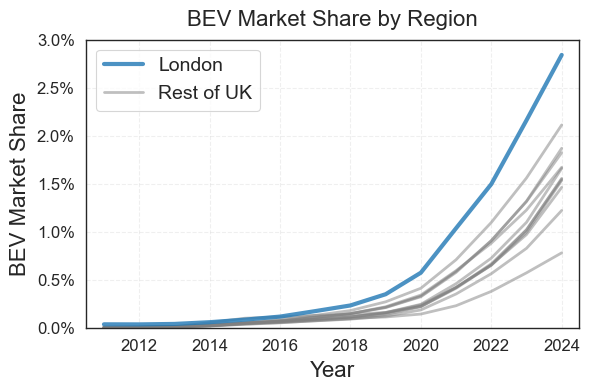

In [716]:
# --- Data Prep ---
regional_df = regional_evms_df.T
years = regional_df.index.values
london_values = regional_df["London"].values
rest_values = regional_df.drop(columns=["London"]).values.T  # shape: (regions, time)

# --- Figure Setup ---
fig, ax = plt.subplots(figsize=(6, 4))

# Customize plot appearance
ax.set_xlim(2010.5, 2024.5)
ax.set_ylim(0, 0.03)
ax.set_xlabel("Year", fontsize=16, labelpad=5)
ax.set_ylabel("BEV Market Share", fontsize=16, labelpad=5)
ax.set_title("BEV Market Share by Region", fontsize=16, pad=10)
ax.grid(axis='both', linestyle='--', alpha=0.3)
ax.tick_params(axis='both', labelsize=12)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

# Empty lines for animation
rest_lines = [ax.plot([], [], color='grey', linewidth=2, alpha=0.5, zorder=1)[0] for _ in range(rest_values.shape[0])]
london_line, = ax.plot([], [], color='C0', linewidth=3, alpha=0.8, zorder=2, label="London")

# Dummy for legend
ax.plot([], [], color='grey', linewidth=2, alpha=0.5, label='Rest of UK')
ax.legend(fontsize=14, loc='upper left')

# --- Animation Function ---
def init():
    """Initialize all lines to be empty."""
    for line in rest_lines:
        line.set_data([], [])
    london_line.set_data([], [])
    return rest_lines + [london_line]

def animate(frame):
    """Update lines for each frame with smooth transition."""
    # Show data up to current frame
    x = years[:frame+1]
    
    # Rest of UK (all grey lines)
    for i, line in enumerate(rest_lines):
        y = rest_values[i, :frame+1]
        line.set_data(x, y)
    
    # London line
    london_line.set_data(x, london_values[:frame+1])
    
    return rest_lines + [london_line]

# --- Create Animation ---
frames = len(years)
anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=frames, interval=200, blit=True, repeat=False
)

# --- Save as GIF (no looping) ---
writer = PillowWriter(fps=4) 
plt.tight_layout()

anim.save("plots/regional_bev_adoption.gif", writer=writer, dpi=150)

plt.show()

plt.close(fig)

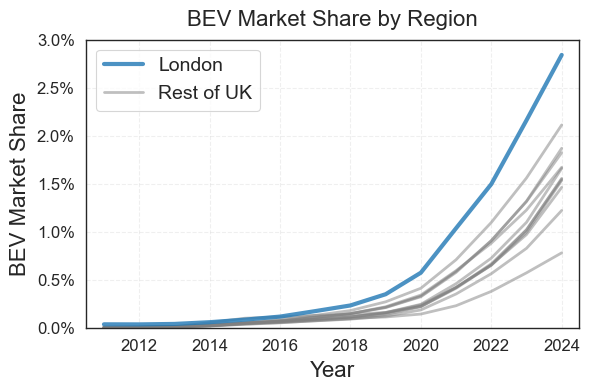

In [ ]:
# Transpose the dataframe for plotting
regional_df = regional_evms_df.T

plt.figure(figsize=(6, 4))

# Plot all regions except London in light gray, no legend
for col in regional_df.columns:
    if col != "London":
        plt.plot(regional_df.index, regional_df[col], color='grey', linewidth=2, alpha=0.5, zorder=1)

# Plot London in blue with legend
plt.plot(regional_df.index, regional_df["London"], color='C0', linewidth=3, alpha=0.8, label='London', zorder=2)
plt.plot([], [], color='grey', linewidth=2, alpha=0.5, label='Rest of UK', zorder=1)

# Customize the plot
plt.xlim(2010.5, 2024.5)
plt.ylim(0, 0.03)
plt.xlabel("Year", fontsize=16, labelpad=5)
plt.ylabel("BEV Market Share", fontsize=16, labelpad=5)
plt.title("BEV Market Share by Region", fontsize=16, pad=10)
plt.grid(axis='both', linestyle='--', alpha=0.3)
plt.tick_params(axis='both', labelsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig("plots/regional_bev_adoption.png", dpi=300)

plt.show()

### Plotting EV adoption curves for London boroughs

We can visualise the uptake of EVs in each London borough.

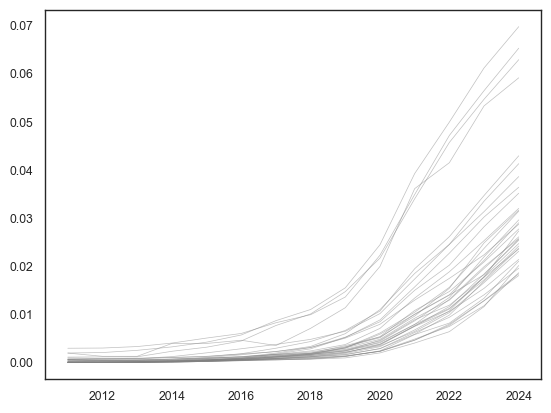

In [9]:
lad_evms_df.T.plot(legend=False, color='grey', alpha=0.5, lw=0.5)
plt.show()

Let's look at the EV market shares for 2024.

In [10]:
lad_evms_df[2024].sort_values(ascending=False).head(5)

LAD
Westminster               0.069789
Camden                    0.065316
Kensington and Chelsea    0.062931
City of London            0.059167
Hammersmith and Fulham    0.042971
Name: 2024, dtype: float64

In [11]:
lad_evms_df[2024].sort_values(ascending=True).head(5)

LAD
Havering                0.018102
Bexley                  0.018458
Waltham Forest          0.018689
Enfield                 0.019625
Barking and Dagenham    0.020182
Name: 2024, dtype: float64

Clearly, Westminster, Camden, Kensington and Chelsea, and City of London  have significantly more EV uptake than other boroughs.

This is likely due to several factors, including the fact that they are generally very affluent areas and all intersect with the congestion zone, where EVs (BEVs) are exempt.

Let's visualise this uptake spatially using a choropleth map (my favorite).

### Loading LAD boundary data

In [13]:
lad_boundaries = gpd.read_file(filename='data/lad_boundaries/LAD_DEC_24_UK_BGC/LAD_DEC_24_UK_BGC.shp')
lad_boundaries.set_index('LAD24NM', inplace=True)
lad_boundaries.drop(columns=['LAD24CD', 'LAD24NMW', 'BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID'], inplace=True)
lad_boundaries.to_crs(25832, inplace=False) # Change CRS to units of meters
london_lad_boundaries = lad_boundaries.loc[london_lad_list] # Filter for London boroughs only
london_lad_boundaries.head()

geometry
LAD24NM                                                                
City of London        MULTIPOLYGON (((531664.799 180549.346, 531628....
Barking and Dagenham  MULTIPOLYGON (((543730.589 184059.079, 543871....
Barnet                POLYGON ((524645.198 198138.303, 524810.701 19...
Bexley                MULTIPOLYGON (((552888.15 175565.3, 552869.5 1...
Brent                 POLYGON ((520455.988 190041.053, 520638.759 18...

Plotting London Borough boundaries.

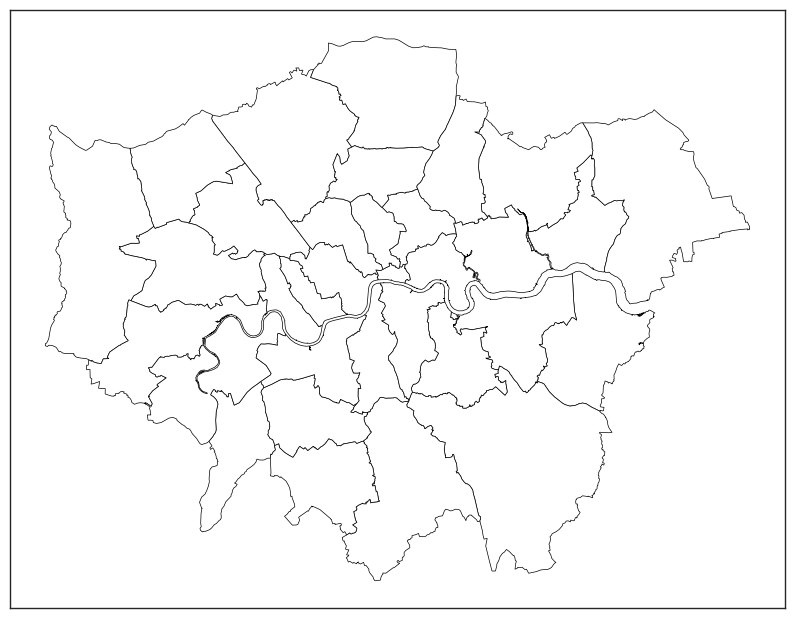

In [499]:
fig, ax = plt.subplots(figsize=(10, 8))
london_lad_boundaries.plot(
    ax=ax,
    color='white',
    edgecolor='black',
    linewidth=0.5,
    
)

ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

plt.show()

### Plotting choropleth maps of EV adoption

Below, we define some plotting functions.

In [701]:
def plot_choropleth(
    gdf, 
    data_series, 
    target_column, 
    cmap, 
    title,
    title_fontsize=16,
    figsize=(8, 12),
    vmin=None, 
    vmax=None,
    percentage=False,
    save_path=None,
    dpi=300
):
    """
    Plot a choropleth map for LAD-level data and optionally save the figure.

    Parameters
    ----------
    gdf : GeoDataFrame
        GeoDataFrame containing geometries for the LAD boundaries.
    data_series : pandas.Series
        Data series with LAD names/index and values to plot.
    target_column : str, optional
        Column name for the choropleth plot.
    cmap : matplotlib colormap, optional
        Colormap for both the map and the bars.
    title : str, optional
        Title for the choropleth map.
    figsize : tuple, optional
        Figure size.
    vmin, vmax : float, optional
        Override min and max for colormap normalization.
    save_path : str, optional
        Path to save the figure. If None, the figure is not saved.
    dpi : int, optional
        Resolution of the saved figure (dots per inch).
    """
    
    fig, ax = plt.subplots(figsize=figsize)

    # --- CHOROPLETH MAP ---
    # Use custom vmin/vmax if provided, otherwise take from data
    vmin = vmin if vmin is not None else data_series.min()
    vmax = vmax if vmax is not None else data_series.max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Combine geometry and data
    plot_gdf = gpd.GeoDataFrame(data_series, geometry=gdf.geometry)
    plot_gdf = plot_gdf.rename(columns={plot_gdf.columns[0]: target_column})

    plot_gdf.plot(
        column=target_column,
        cmap=cmap,
        norm=norm,
        ax=ax,
        edgecolor="black",
        linewidth=0.2,
        legend=False
    )

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.02)
    cbar.ax.tick_params(labelsize=12)

    if percentage == True:
        cbar.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

    # Add scale bar
    ax.add_artist(
        ScaleBar(1, units='m', length_fraction=0.25, location='lower right',
                 font_properties={"size": 14})
    )

    # Remove ticks
    ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

    ax.set_title(title, fontsize=title_fontsize)

    plt.tight_layout()

    plt.show()

    # --- Save ---
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"Figure saved to {save_path}")
        plt.close(fig)

def plot_bar(
    data_series, 
    cmap, 
    title,
    figsize=(8, 5),
    ymin=None,
    ymax=None,
):
    """
    Plot a bar chart for LAD-level data.

    Parameters
    ----------
    data_series : pandas.Series
        Data series with LAD names/index and values to plot.
    cmap : matplotlib colormap
        Colormap for both the map and the bars.
    title : str
        Title for the choropleth map.
    figsize : tuple, optional
        Figure size.
    ymin, ymax : float, optional
        Override min and max limits for the bar chart y-axis.
    """
    
    fig, ax = plt.subplots(figsize=figsize)
        
    vmin = ymin if ymin is not None else data_series.min()
    vmax = ymax if ymax is not None else data_series.max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    sorted_vals = data_series.sort_values(ascending=False)
    colors = [cmap(norm(val)) for val in sorted_vals.values]

    sorted_vals.plot.bar(
        ax=ax,
        width=0.8,
        alpha=1,
        color=colors,
        edgecolor='black'
    )

    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', labelsize=11, rotation=90)
    ax.tick_params(axis='y', labelsize=12)
    ax.set_xlabel('Borough', fontsize=16)
    ax.set_title(title, fontsize='16')

    # Apply custom y-axis limits if provided
    if ymin is not None or ymax is not None:
        ax.set_ylim(bottom=ymin if ymin is not None else ax.get_ylim()[0],
                    top=ymax if ymax is not None else ax.get_ylim()[1])

    plt.tight_layout()
    plt.show()

def plot_choropleth_with_bar(
    gdf, 
    data_series, 
    target_column, 
    cmap,
    title,
    title_fontsize=16,
    figsize=(8, 10),
    vmin=None, 
    vmax=None, 
    ymin=None, 
    ymax=None,
    percentage=False,
    alphabetical=False,
    save_path=None,
    dpi=300
):
    """
    Plot a choropleth map and a matching bar chart for LAD-level data.

    Parameters
    ----------
    gdf : GeoDataFrame
        GeoDataFrame containing geometries for the LAD boundaries.
    data_series : pandas.Series
        Data series with LAD names/index and values to plot.
    target_column : str
        Column name for the choropleth plot.
    cmap : matplotlib colormap
        Colormap for both the map and the bars.
    title : str
        Title for the choropleth map.
    figsize : tuple, optional
        Figure size.
    vmin, vmax : float, optional
        Override min and max for colormap normalization.
    ymin, ymax : float, optional
        Override min and max limits for the bar chart y-axis.
    save_path : str, optional
        Path to save the figure. If None, the figure is not saved.
    dpi : int, optional
        Resolution of the saved figure (dots per inch).
    """
    
    fig, axes = plt.subplots(2, 1, figsize=figsize, height_ratios=[4, 1])

    # --- CHOROPLETH MAP ---
    # Use custom vmin/vmax if provided, otherwise take from data
    vmin = vmin if vmin is not None else data_series.min()
    vmax = vmax if vmax is not None else data_series.max()
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Combine geometry and data
    plot_gdf = gpd.GeoDataFrame(data_series, geometry=gdf.geometry)
    plot_gdf = plot_gdf.rename(columns={plot_gdf.columns[0]: target_column})

    plot_gdf.plot(
        column=target_column,
        cmap=cmap,
        norm=norm,
        ax=axes[0],
        edgecolor="black",
        linewidth=0.2,
        legend=False
    )

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    cbar = fig.colorbar(sm, ax=axes[0], fraction=0.036, pad=0.02)
    cbar.ax.tick_params(labelsize=12)

    if percentage == True:
        cbar.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

    # Add scale bar
    axes[0].add_artist(
        ScaleBar(1, units='m', length_fraction=0.25, location='lower right',
                 font_properties={"size": 14})
    )

    # Remove ticks
    axes[0].tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

    axes[0].set_title(title, fontsize=title_fontsize)

    # --- BAR CHART ---
    if alphabetical == False:
        sorted_vals = data_series.sort_values(ascending=False)
        colors = [cmap(norm(val)) for val in sorted_vals.values]
    if alphabetical == True:
        sorted_vals = data_series.sort_index()
        colors = [cmap(norm(val)) for val in sorted_vals.values]

    sorted_vals.plot.bar(
        ax=axes[1],
        width=0.8,
        alpha=1,
        color=colors,
        edgecolor='black'
    )

    axes[1].grid(axis='y', linestyle='--', alpha=0.5)
    axes[1].tick_params(axis='x', labelsize=11, rotation=90)
    axes[1].tick_params(axis='y', labelsize=12)
    axes[1].set_xlabel('Borough', fontsize=16)

    if percentage == True:
        axes[1].yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

    # Apply custom y-axis limits if provided
    if ymin is not None or ymax is not None:
        axes[1].set_ylim(bottom=ymin if ymin is not None else axes[1].get_ylim()[0],
                         top=ymax if ymax is not None else axes[1].get_ylim()[1])

    plt.tight_layout()
    plt.show()

    # --- Save ---
    if save_path:
        fig.savefig(save_path, dpi=dpi, bbox_inches="tight")
        print(f"Figure saved to {save_path}")
        plt.close(fig)

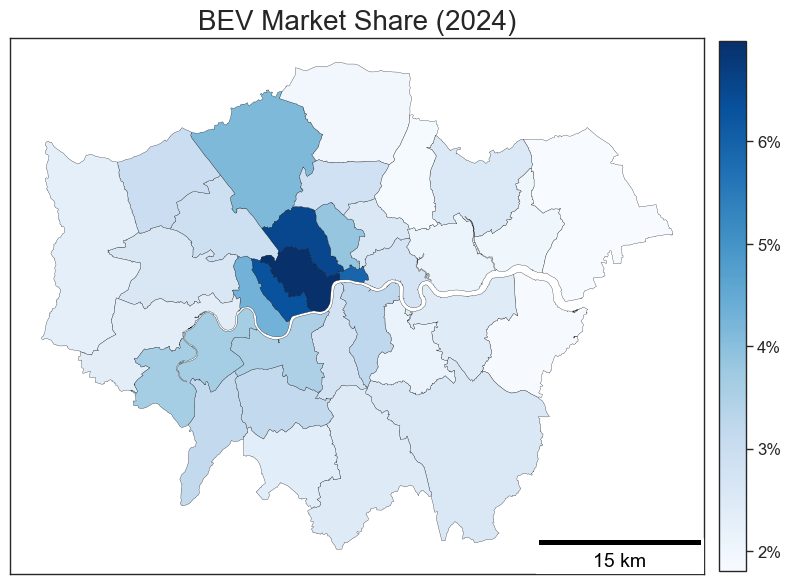

Figure saved to plots/bev_market_share_2024.png


In [720]:
plot_choropleth(
    gdf=london_lad_boundaries, 
    data_series=lad_evms_df[2024],
    target_column=2024,
    cmap=plt.cm.Blues,
    title='BEV Market Share (2024)',
    title_fontsize=20,
    percentage=True,
    save_path='plots/bev_market_share_2024.png',
    dpi=300
)

Let's plot a gif of the evolution of EV market share.

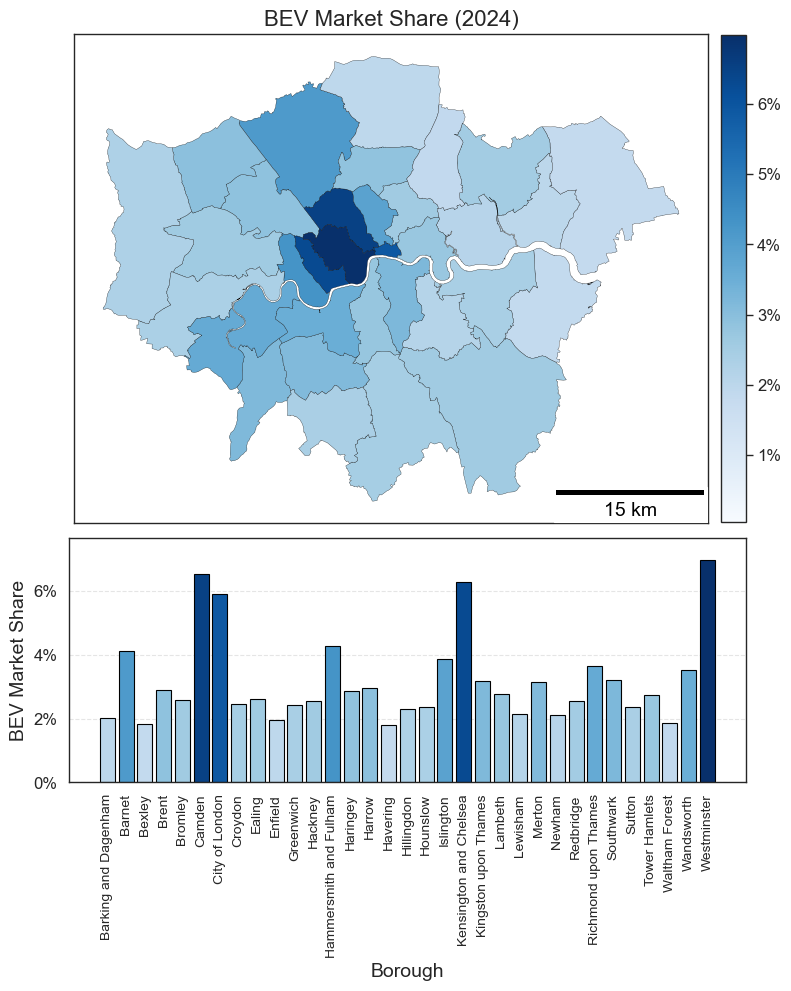

In [691]:
# --- CONFIG ---
years = list(range(2016, 2025))  # 2016 to 2024
vmin = lad_evms_df[years].min().min()  # Global min for consistent colors
vmax = lad_evms_df[years].max().max()  # Global max for consistent colors
cmap = plt.cm.Blues

# --- SETUP FIGURE WITH TWO SUBPLOTS ---
fig, (ax_map, ax_bar) = plt.subplots(
    2, 1, figsize=(8, 10), gridspec_kw={'height_ratios': [2, 1]}
)

# --- COLORBAR SETUP ---
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.02)
cbar.ax.tick_params(labelsize=12)
# Format colorbar ticks as percentages with 1 decimal place
cbar.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

# --- STATIC MAP SETTINGS ---
ax_map.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

# Initial GeoDataFrame for plotting
gdf = gpd.GeoDataFrame(geometry=london_lad_boundaries.geometry)

# --- INITIAL BAR CHART SETTINGS ---
ax_bar.set_ylabel("BEV Market Share", fontsize=14)
ax_bar.set_xlabel("Borough", fontsize=14)
ax_bar.tick_params(axis='x', labelsize=10, rotation=90)
ax_bar.tick_params(axis='y', labelsize=12)
ax_bar.grid(axis='y', linestyle='--', alpha=0.5)
ax_bar.set_ylim(0, lad_evms_df[years].values.max() * 1.1)
# Format y-axis of bar chart as percentages
ax_bar.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

# --- UPDATE FUNCTION ---
def update(frame_idx):
    year = years[frame_idx]

    # ===== Update Choropleth Map =====
    ax_map.clear()
    ax_map.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)
    ax_map.add_artist(
        ScaleBar(1, units='m', length_fraction=0.25, location='lower right',
                 font_properties={"size": 14})
    )

    gdf["EVMS"] = lad_evms_df[year]
    gdf.plot(
        column="EVMS",
        cmap=cmap,
        norm=norm,
        ax=ax_map,
        edgecolor="black",
        linewidth=0.2,
        legend=False
    )
    ax_map.set_title(f'BEV Market Share ({year})', fontsize=16)

    # ===== Update Bar Chart =====
    ax_bar.clear()
    ax_bar.set_ylabel("BEV Market Share", fontsize=14)
    ax_bar.set_xlabel("Borough", fontsize=14)
    ax_bar.grid(axis='y', linestyle='--', alpha=0.5)
    ax_bar.tick_params(axis='x', labelsize=10, rotation=90)
    ax_bar.tick_params(axis='y', labelsize=12)
    ax_bar.set_ylim(0, lad_evms_df[years].values.max() * 1.1)
    # Ensure bar chart y-axis stays formatted as percentage after clearing
    ax_bar.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=0))

    # Sort alphabetically by borough name
    sorted_vals = lad_evms_df[year].sort_index()
    colors = [cmap(norm(val)) for val in sorted_vals.values]

    ax_bar.bar(sorted_vals.index, sorted_vals.values, color=colors, edgecolor='black')

    plt.tight_layout()

    return []

# --- CREATE ANIMATION ---
anim = FuncAnimation(
    fig,
    update,
    frames=len(years),
    interval=500,  # time between frames in ms
    blit=False     # blit=False because we clear both plots each frame
)

# --- SAVE ANIMATION ---
anim.save("plots/ev_market_share_map_bar.gif", writer=PillowWriter(fps=1.5), dpi=300)

plt.show()
plt.close(fig)

# Exploring Additional Datasets of Interest

### Off-street parking data

Here, we load in data from the standing still report by the RAC.

In [75]:
standing_still_df = pd.read_csv('data/standing_still/standing_still_off_street_parking_by_LA_A-Z.csv', thousands=',').set_index('GB Local Authority District')
standing_still_df = standing_still_df.iloc[:, :3]
standing_still_df = standing_still_df .rename(index={"City of Westminster": "Westminster"})
standing_still_df['p_osp'] = standing_still_df['Households with off-street parking or parking potential'] / standing_still_df['Total households']
standing_still_df = standing_still_df.loc[london_lad_list] # Filter for London boroughs
standing_still_df.head()

Total households  \
GB Local Authority District                     
City of London                           6587   
Barking and Dagenham                    74316   
Barnet                                 142776   
Bexley                                  97593   
Brent                                   99546   

                             Households with off-street parking or parking potential  \
GB Local Authority District                                                            
City of London                                                               5         
Barking and Dagenham                                                     45756         
Barnet                                                                   77941         
Bexley                                                                   69143         
Brent                                                                    51075         

                             Households without off-street parking or parking potential  \
GB Local Authority District                                                               
City of London                                                            6582            
Barking and Dagenham                                                     28560            
Barnet                                                                   64835            
Bexley                                                                   28450            
Brent                                                                    48471            

                                p_osp  
GB Local Authority District            
City of London               0.000759  
Barking and Dagenham         0.615695  
Barnet                       0.545897  
Bexley                       0.708483  
Brent                        0.513079

Let's plot this data on a choropleth map

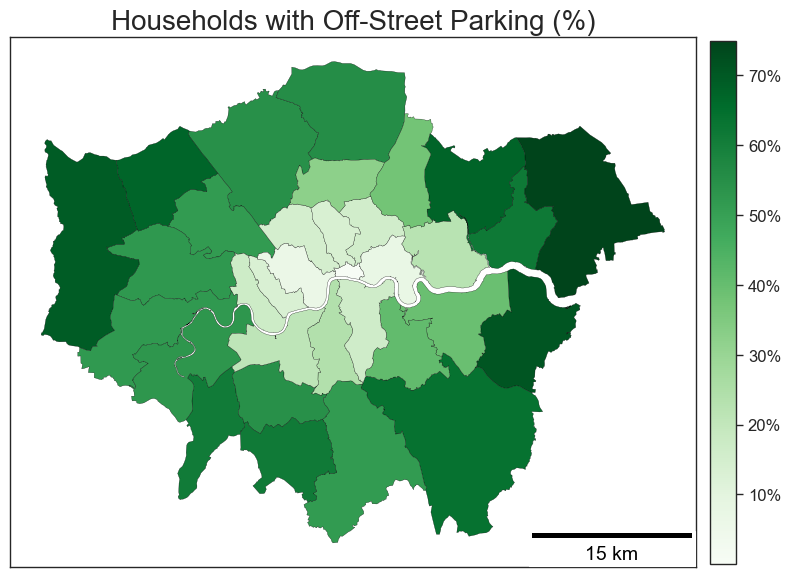

Figure saved to plots/households_with_osp.png


In [705]:
plot_choropleth(
    gdf=london_lad_boundaries, 
    data_series=standing_still_df['p_osp'],
    target_column='p_osp',
    cmap=plt.cm.Greens,
    title='Households with Off-Street Parking (%)',
    title_fontsize=20,
    percentage=True,
    save_path='plots/households_with_osp.png',
    dpi=300
)

### Public Charger Data

We access public charger data from the OpenChargeMap API.

In [86]:
os.environ['USE_PYGEOS'] = '0'
from requests import get

endpoint = ('https://api.openchargemap.io/v3/poi/') # Using the OpenChargeMap API

parameters = {
    'countrycode':'GB',
    'maxresults': 1000000,
    'key': 'b7c88c66-3a61-401e-8b9e-437f66554a9d' # My unique API Key
}

response = get(endpoint, params = parameters)
json_data = response.json()
json_data

[{'DataProvider': {'WebsiteURL': 'http://openchargemap.org',
   'Comments': None,
   'DataProviderStatusType': {'IsProviderEnabled': True,
    'ID': 1,
    'Title': 'Manual Data Entry'},
   'IsRestrictedEdit': False,
   'IsOpenDataLicensed': True,
   'IsApprovedImport': True,
   'License': 'Licensed under Creative Commons Attribution 4.0 International (CC BY 4.0)',
   'DateLastImported': None,
   'ID': 1,
   'Title': 'Open Charge Map Contributors'},
  'OperatorInfo': {'WebsiteURL': 'https://map.zest.uk.com/',
   'Comments': 'bespoke mobile phone app required',
   'PhonePrimaryContact': '+44 333 577 6760',
   'PhoneSecondaryContact': None,
   'IsPrivateIndividual': False,
   'AddressInfo': None,
   'BookingURL': None,
   'ContactEmail': None,
   'FaultReportEmail': None,
   'IsRestrictedEdit': False,
   'ID': 3581,
   'Title': 'Zest Charging'},
  'UsageType': {'IsPayAtLocation': False,
   'IsMembershipRequired': True,
   'IsAccessKeyRequired': True,
   'ID': 4,
   'Title': 'Public - Mem

In [87]:
def json_to_dataframe(json_data, column_names):
    
    df = pd.DataFrame(columns = column_names)

    for i in tqdm(range(len(json_data))):
        if len(json_data[i]['Connections']) > 1:
            for j in range(len(json_data[i]['Connections'])):
                try:
                    mapper = {
                        'ID': str(json_data[i]['AddressInfo']['ID']),
                        'Title': str(json_data[i]['AddressInfo']['Title']),
                        'Town': str(json_data[i]['AddressInfo']['Town']),
                        'Operator': json_data[i]['OperatorInfo']['Title'],
                        'Operational': json_data[i]['Connections'][j]['StatusType']['IsOperational'],
                        'Connection_Type': json_data[i]['Connections'][j]['ConnectionType']['Title'],
                        'Number_of_Points': json_data[i]['Connections'][j]['Quantity'],
                        'Current_Type': json_data[i]['Connections'][j]['CurrentType']['Title'],
                        'Power_KW': json_data[i]['Connections'][j]['PowerKW'],
                        'Usage': json_data[i]['UsageType']['Title'],
                        'Cost': json_data[i]['UsageCost'],
                        'Latitude': json_data[i]['AddressInfo']['Latitude'],
                        'Longitude': json_data[i]['AddressInfo']['Longitude'],
                        }
                    s = pd.Series(mapper)
                    df = pd.concat([df, s.to_frame().T], ignore_index=True, axis=0)
                except:
                    pass
        else:
            try:
                mapper = {
                    'ID': str(json_data[i]['AddressInfo']['ID']),
                    'Title': str(json_data[i]['AddressInfo']['Title']),
                    'Town': str(json_data[i]['AddressInfo']['Town']),
                    'Operator': json_data[i]['OperatorInfo']['Title'],
                    'Operational': json_data[i]['Connections'][0]['StatusType']['IsOperational'],
                    'Connection_Type': json_data[i]['Connections'][0]['ConnectionType']['Title'],
                    'Number_of_Points': json_data[i]['NumberOfPoints'],
                    'Current_Type': json_data[i]['Connections'][0]['CurrentType']['Title'],
                    'Power_KW': json_data[i]['Connections'][0]['PowerKW'],
                    'Usage': json_data[i]['UsageType']['Title'],
                    'Cost': json_data[i]['UsageCost'],
                    'Latitude': json_data[i]['AddressInfo']['Latitude'],
                    'Longitude': json_data[i]['AddressInfo']['Longitude']
                }
                s = pd.Series(mapper)
                df = pd.concat([df, s.to_frame().T], ignore_index=True, axis=0)
            except:
                pass
    return df

In [88]:
column_names = [
    'ID', 
    'Title', 
    'Town',
    'Operator', 
    'Operational', 
    'Connection_Type', 
    'Number_of_Points', 
    'Current_Type', 
    'Power_KW', 
    'Usage',
    'Cost',
    'Latitude', 
    'Longitude'
]

GB_chargers_df = json_to_dataframe(json_data, column_names)
GB_chargers_df.head()

ID                  Title       Town       Operator Operational  \
0  461486          Home Bargains  Ballykeel  Zest Charging        True   
1  461485          Home Bargains       None  Zest Charging        True   
2  461484  Kennedy Centre (Rear)    Belfast  Zest Charging        True   
3  461483             McDonald's     Bangor  InstaVolt Ltd        True   
4  461483             McDonald's     Bangor  InstaVolt Ltd        True   

        Connection_Type Number_of_Points      Current_Type Power_KW  \
0  Type 2 (Socket Only)                4  AC (Three-Phase)       22   
1  Type 2 (Socket Only)                4  AC (Three-Phase)       22   
2          CCS (Type 2)                6                DC     None   
3          CCS (Type 2)                2                DC     None   
4               CHAdeMO                1                DC     None   

                          Usage  Cost   Latitude Longitude  
0  Public - Membership Required  None  54.856869 -6.277695  
1  Public - Membership Required  None  54.711569 -5.826839  
2  Public - Membership Required  None  54.582131 -5.978269  
3  Public - Membership Required  None  54.647116 -5.658857  
4  Public - Membership Required  None  54.647116 -5.658857

In [89]:
GB_chargers_gdf = gpd.GeoDataFrame(GB_chargers_df, geometry=gpd.points_from_xy(GB_chargers_df.Longitude, GB_chargers_df.Latitude))
GB_chargers_gdf.crs = 'epsg:4326'
GB_chargers_gdf.head()

ID                  Title       Town       Operator Operational  \
0  461486          Home Bargains  Ballykeel  Zest Charging        True   
1  461485          Home Bargains       None  Zest Charging        True   
2  461484  Kennedy Centre (Rear)    Belfast  Zest Charging        True   
3  461483             McDonald's     Bangor  InstaVolt Ltd        True   
4  461483             McDonald's     Bangor  InstaVolt Ltd        True   

        Connection_Type Number_of_Points      Current_Type Power_KW  \
0  Type 2 (Socket Only)                4  AC (Three-Phase)       22   
1  Type 2 (Socket Only)                4  AC (Three-Phase)       22   
2          CCS (Type 2)                6                DC     None   
3          CCS (Type 2)                2                DC     None   
4               CHAdeMO                1                DC     None   

                          Usage  Cost   Latitude Longitude  \
0  Public - Membership Required  None  54.856869 -6.277695   
1  Public - Membership Required  None  54.711569 -5.826839   
2  Public - Membership Required  None  54.582131 -5.978269   
3  Public - Membership Required  None  54.647116 -5.658857   
4  Public - Membership Required  None  54.647116 -5.658857   

                    geometry  
0  POINT (-6.27769 54.85687)  
1  POINT (-5.82684 54.71157)  
2  POINT (-5.97827 54.58213)  
3  POINT (-5.65886 54.64712)  
4  POINT (-5.65886 54.64712)

Saving the data as a pickle file.

In [90]:
GB_chargers_gdf.to_pickle('data/public_chargers/GB_public_charger_locations_ocm.pkl')

Filtering for public chargers in London.

In [724]:
london_public_chargers_gdf = GB_chargers_gdf.loc[GB_chargers_gdf.within(london_lad_boundaries.to_crs('epsg:4326').union_all())].reset_index(drop=True)

Calculating the number of charging points.

In [ ]:
london_public_chargers_gdf['Number_of_Points'] = london_public_chargers_gdf['Number_of_Points'].astype(float).fillna(1.0)

Calculating the total number of public chargers in London.

In [700]:
london_public_chargers_gdf['Number_of_Points'].sum()

20070.0

Plotting public charger locations.

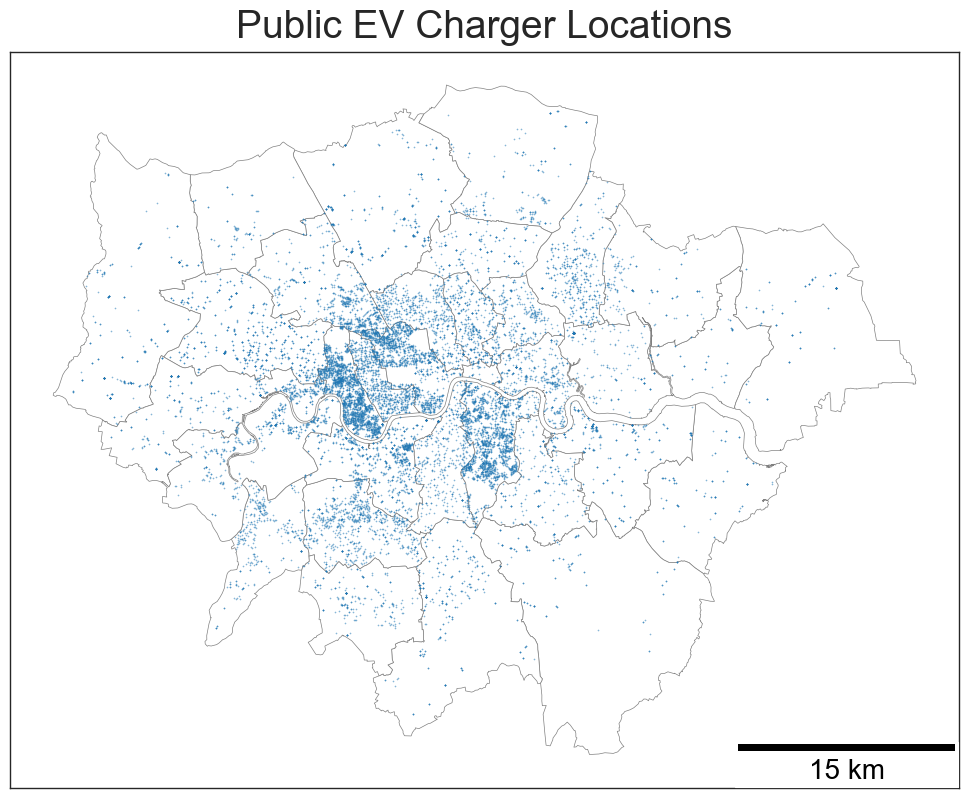

In [703]:
fig, ax = plt.subplots(figsize=(10, 8))

london_lad_boundaries.to_crs(25832).plot(
    ax=ax,
    color='white',
    edgecolor='grey',
    linewidth=0.5,
    
)

london_public_chargers_gdf.to_crs(25832).plot(
    ax=ax,
    markersize=0.1,
    color='C0',
    alpha=0.7
)

# Add scale bar
ax.add_artist(
    ScaleBar(1, units='m', length_fraction=0.25, location='lower right',
                font_properties={"size": 20})
)

# Remove ticks
ax.tick_params(left=False, labelleft=False, labelbottom=False, bottom=False)

ax.set_title('Public EV Charger Locations', fontsize=28, pad=10)

plt.tight_layout()

plt.savefig('plots/public_charger_locations.png', dpi=300)

plt.show()

In [156]:
# Spatial join once for all LADs
joined = gpd.sjoin(london_public_chargers_gdf, london_lad_boundaries.to_crs('epsg:4326'), how="inner", predicate="within")
london_lad_public_chargers = joined.groupby('LAD24NM')['Number_of_Points'].sum()
london_lad_public_chargers.head()

LAD24NM
Barking and Dagenham    125.0
Barnet                  530.0
Bexley                  154.0
Brent                   813.0
Bromley                 197.0
Name: Number_of_Points, dtype: float64

Let's plot this data on ANOTHER choropleth

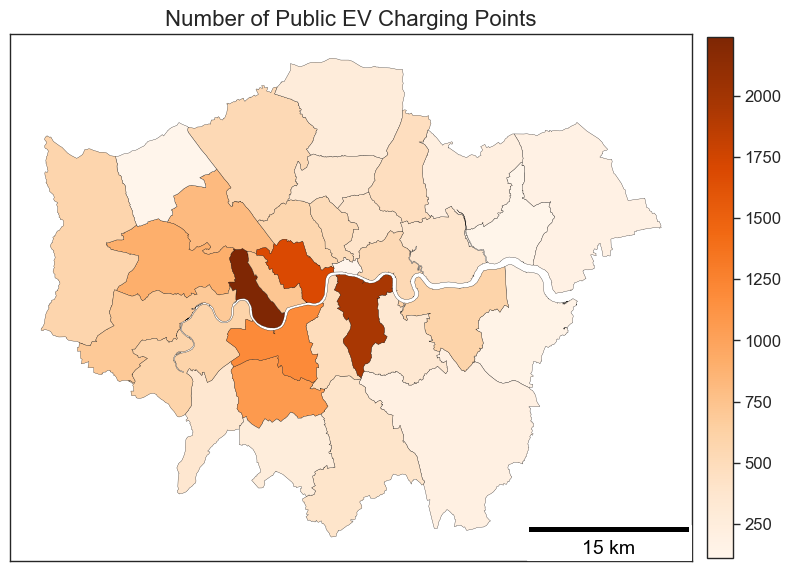

Figure saved to plots/public_chargers.png


In [530]:
plot_choropleth(
    gdf=london_lad_boundaries, 
    data_series=london_lad_public_chargers,
    target_column=0,
    cmap=plt.cm.Oranges,
    title='Number of Public EV Charging Points',
    save_path='plots/public_chargers.png',
    dpi=300
)

What about public chargers per BEV?

In [113]:
public_chargers_per_bev = london_lad_public_chargers / lad_ev_df[2024]
public_chargers_per_bev.head()

Barking and Dagenham    0.102712
Barnet                  0.098641
Bexley                  0.085224
Brent                   0.343618
Bromley                 0.056093
dtype: float64

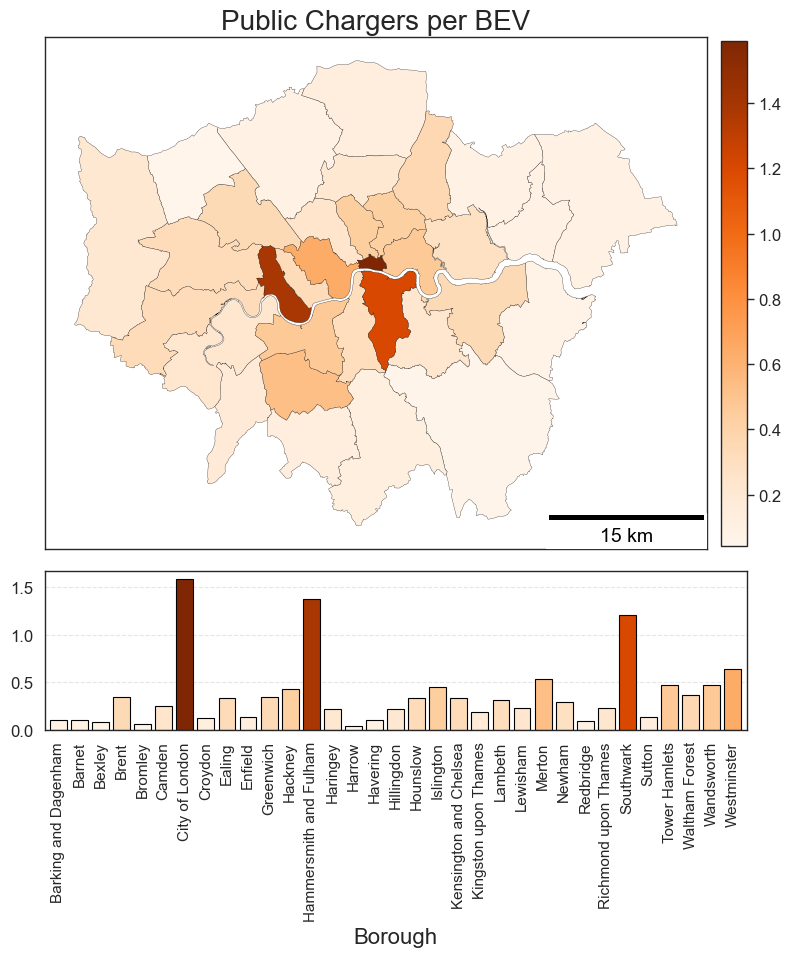

Figure saved to plots/public_chargers_per_bev.png


In [704]:
plot_choropleth_with_bar(
    gdf=london_lad_boundaries, 
    data_series=public_chargers_per_bev,
    target_column=0,
    cmap=plt.cm.Oranges,
    title='Public Chargers per BEV',
    title_fontsize=20,
    alphabetical=True,
    save_path='plots/public_chargers_per_bev.png',
    dpi=300
)

### Car Ownership

Let's take a look at the rates of car ownership amoungst London Boroughs. Here we use data from the 2021 Census on car and van availability.

In [189]:
census_cars = pd.read_csv('data/Census 2021/car_and_van_availability.csv')
census_cars.head()

Lower tier local authorities Code Lower tier local authorities  \
0                         E06000001                   Hartlepool   
1                         E06000001                   Hartlepool   
2                         E06000001                   Hartlepool   
3                         E06000001                   Hartlepool   
4                         E06000001                   Hartlepool   

   Car or van availability (5 categories) Code  \
0                                           -8   
1                                            0   
2                                            1   
3                                            2   
4                                            3   

  Car or van availability (5 categories)  Observation  
0                         Does not apply            0  
1           No cars or vans in household        12102  
2              1 car or van in household        16635  
3            2 cars or vans in household         9259  
4    3 or more cars or vans in household         2934

In [725]:
census_cars = census_cars[census_cars['Car or van availability (5 categories) Code'] != -8]
census_cars['car_counts'] = (census_cars['Car or van availability (5 categories) Code'] * census_cars['Observation'])

# Filter for london LADs.
london_census_cars = census_cars.set_index('Lower tier local authorities').loc[london_lad_list]
london_census_cars.head()

Lower tier local authorities Code  \
Lower tier local authorities                                     
City of London                                       E09000001   
City of London                                       E09000001   
City of London                                       E09000001   
City of London                                       E09000001   
Barking and Dagenham                                 E09000002   

                              Car or van availability (5 categories) Code  \
Lower tier local authorities                                                
City of London                                                          0   
City of London                                                          1   
City of London                                                          2   
City of London                                                          3   
Barking and Dagenham                                                    0   

                             Car or van availability (5 categories)  \
Lower tier local authorities                                          
City of London                         No cars or vans in household   
City of London                            1 car or van in household   
City of London                          2 cars or vans in household   
City of London                  3 or more cars or vans in household   
Barking and Dagenham                   No cars or vans in household   

                              Observation  car_counts  
Lower tier local authorities                           
City of London                       3793           0  
City of London                        954         954  
City of London                        123         246  
City of London                         43         129  
Barking and Dagenham                25682           0

Adding up the total number of cars in each borough.

In [271]:
london_census_cars_total = london_census_cars.groupby('Lower tier local authorities')['car_counts'].sum()
london_census_cars_total.head()

Lower tier local authorities
Barking and Dagenham     66369
Barnet                  149954
Bexley                  112819
Brent                    91019
Bromley                 157314
Name: car_counts, dtype: int64

How many cars per household?

In [ ]:
cars_per_household = london_census_cars_total / standing_still_df.loc[london_lad_list, 'Total households']

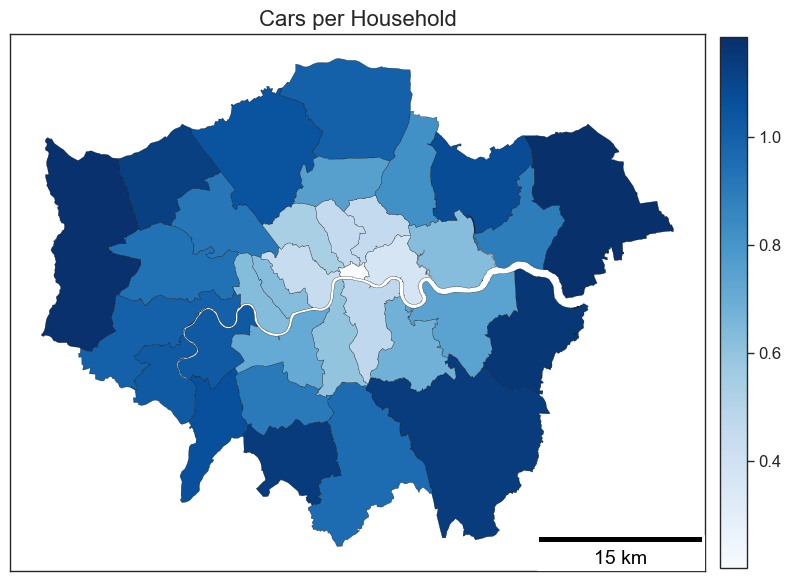

In [323]:
plot_choropleth(
    gdf=london_lad_boundaries, 
    data_series=cars_per_household,
    target_column=0,
    cmap=plt.cm.Blues,
    title='Cars per Household'
)

How many cars do household who own at least one car have?

In [ ]:
households_with_cars = london_census_cars[london_census_cars['Car or van availability (5 categories) Code'] != 0]['Observation'].groupby('Lower tier local authorities').sum()
cars_per_household_with_cars = london_census_cars_total / households_with_cars

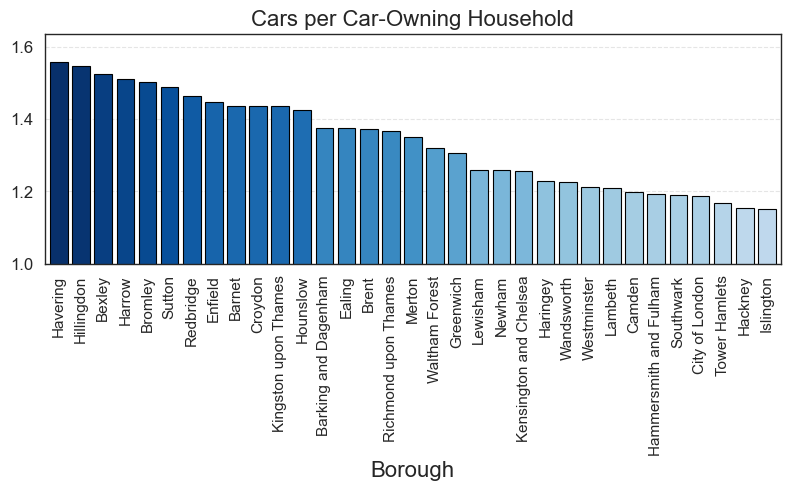

In [392]:
plot_bar(
    data_series=cars_per_household_with_cars,
    cmap=plt.cm.Blues,
    title='Cars per Car-Owning Household',
    ymin=1
)

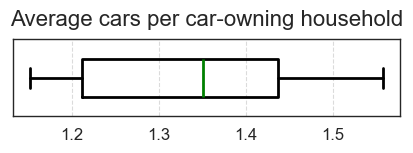

In [440]:
fig, ax = plt.subplots(figsize=(5, 1))
cars_per_household_with_cars.plot.box(
    vert=False, 
    widths=0.5, 
    boxprops = dict(linestyle='-',linewidth=2.0, color='black'),
    whiskerprops = dict(linestyle='-',linewidth=2.0, color='black'),
    capprops = dict(linestyle='-',linewidth=2.0, color='black'),
    medianprops = dict(linestyle='-',linewidth=2.0, color='green'),
)
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.set_title('Average cars per car-owning household', fontsize=16, pad=10)
ax.tick_params(labelsize=12)
plt.show()

# Estimating the number of additional public chargers that would need to be installed to support a 100% BEV Domestic Fleet.

The following factors will affect the number of required public chargers:
- Number of BEVs
- Average vehicles per off-street household
- Total off-street households
- BEVs per charger
- Proportion of on-street BEVs without home charging.

$$ \begin{align}

\text{On-Street Vehicles} &= \text{Number of Vehicles} - (\text{Vehicles Per Off-Street Parking Household} \times \text{Off-Street Parking Households}) \\

\text{On-Street BEVs} &= \text{BEV Market Share} \times \text{On-Street Vehicles} \\

\text{Required Public Chargers} &= \frac{\text{Proportion of On-Street BEVs Without Home Charging} \times \text{On-Street BEVs}}{\text{BEVs Per Charger}} \\

\end{align} $$

Let's assume all households with off-street parking access have 2 vehicles, representing a low-ball estimate for the number of required public chargers.

Of course, we don't nessesarily need one public charger per BEV without a dedicated off-street home charger. Therefore, let's say that 1 charger can support 2 BEVs.

The proportion of on-street BEVs without home charging access is difficult to calculate. For the purposes of this analysis, let's assume that half of the On-Street BEVs rely solely on public charging.

In [ ]:
def calculate_on_street_vehicles(
    v_series, 
    osp_series, 
    osp_occupancy,
):
    v_series, osp_series = v_series.align(osp_series, join='inner')
    return np.ceil((v_series - osp_occupancy*osp_series)).clip(lower=0)

def calculate_on_street_bevs(
        on_street_vehicles,
        bev_market_share
):
    return bev_market_share * on_street_vehicles

def calculate_required_on_street_chargers(
        on_street_bevs,
        bevs_per_charger
):
    return np.ceil(on_street_bevs / bevs_per_charger)

def calculate_required_public_chargers(
        required_on_street_chargers,
        p_no_home,
):
    return np.ceil(p_no_home*required_on_street_chargers)

def calculate_additional_required_public_chargers(
        required_public_chargers,
        existing_public_chargers
):
    return np.clip(required_public_chargers - existing_public_chargers, 0, np.inf)

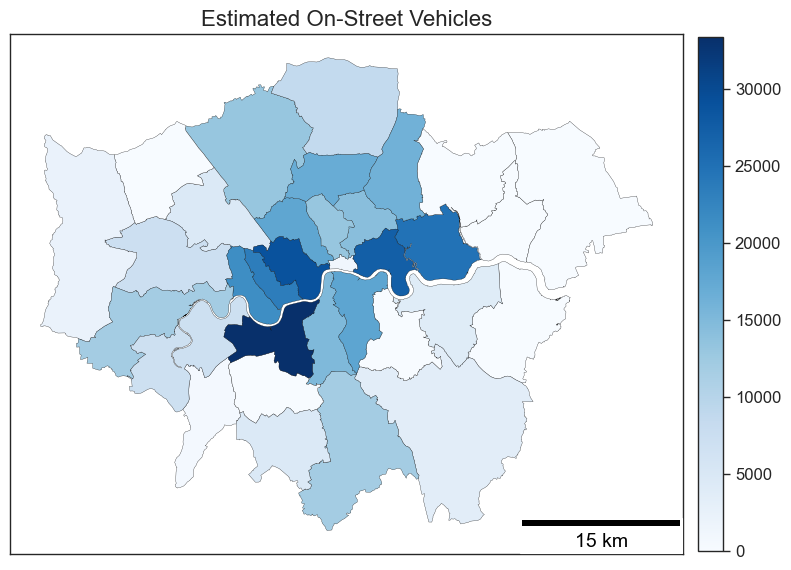

Figure saved to plots/on_street_vehicles


In [ ]:
on_street_vehicles = calculate_on_street_vehicles(
    v_series=lad_v_df[2024], 
    osp_series=standing_still_df.loc[london_lad_list, 'Households with off-street parking or parking potential'],
    osp_occupancy=1.5,
)

plot_choropleth(
    gdf=london_lad_boundaries, 
    data_series=on_street_vehicles,
    target_column=0,
    cmap=plt.cm.Blues,
    title='Estimated On-Street Vehicles',
    vmin=0,
    save_path='plots/on_street_vehicles',
    dpi=300
)

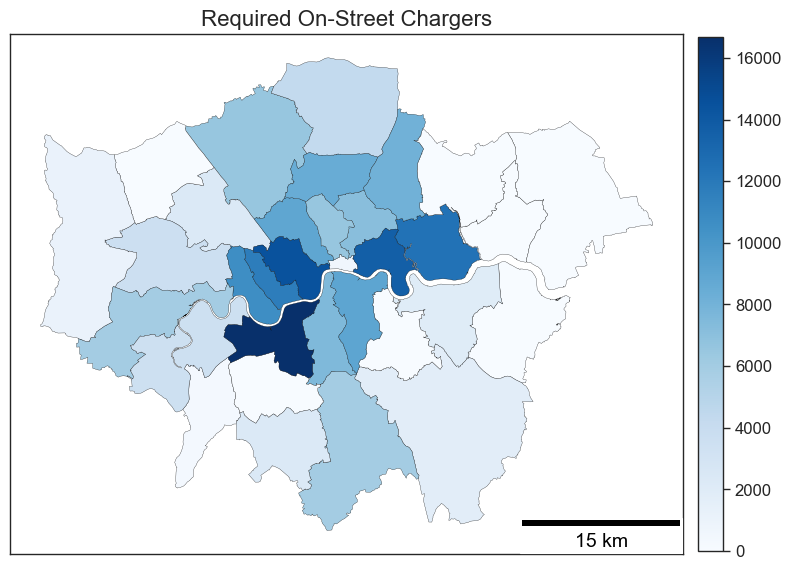

In [726]:
on_street_bevs = calculate_on_street_bevs(
        on_street_vehicles=on_street_vehicles,
        bev_market_share=1
)

required_on_street_chargers = calculate_required_on_street_chargers(
        on_street_bevs=on_street_bevs,
        bevs_per_charger=2
)

plot_choropleth(
    gdf=london_lad_boundaries, 
    data_series=required_on_street_chargers,
    target_column=0,
    cmap=plt.cm.Blues,
    title='Required On-Street Chargers',
    vmin=0,
)

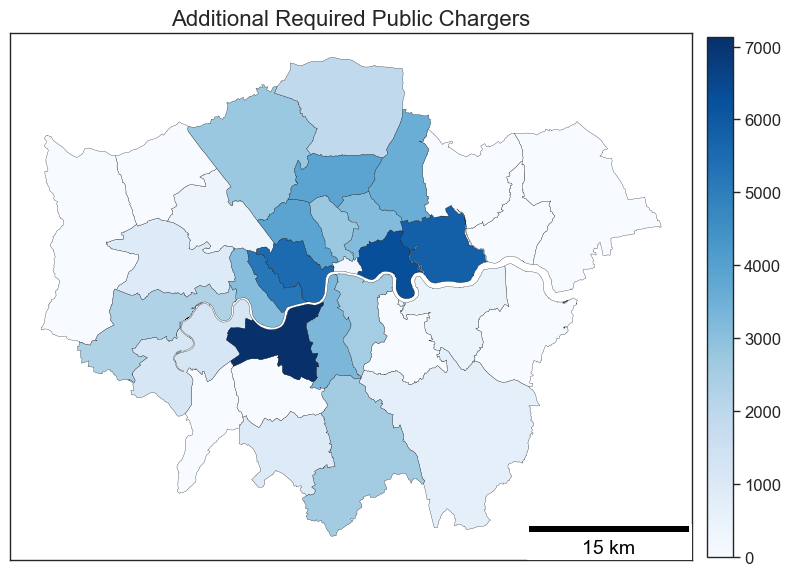

In [727]:
required_public_chargers = calculate_required_public_chargers(
    required_on_street_chargers=required_on_street_chargers,
    p_no_home=0.5
)

additional_required_public_chargers = calculate_additional_required_public_chargers(
        required_public_chargers=required_public_chargers,
        existing_public_chargers=london_lad_public_chargers
)

plot_choropleth(
    gdf=london_lad_boundaries, 
    data_series=additional_required_public_chargers ,
    target_column=0,
    cmap=plt.cm.Blues,
    title='Additional Required Public Chargers',
    vmin=0,
#     vmax=53000,
)

We can plot the additional required public chargers as a stacked bar chart.

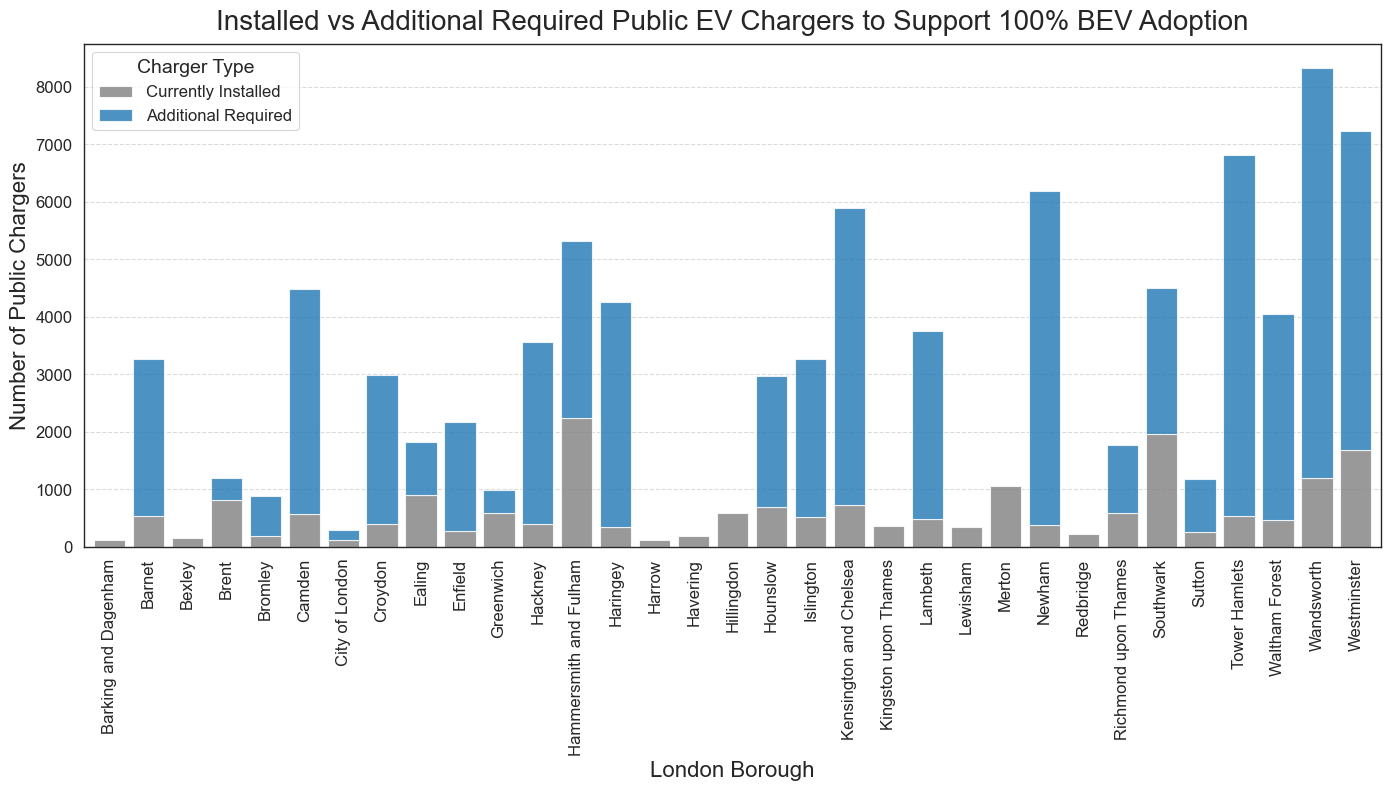

In [565]:
# Example data (replace with your actual series)
current = london_lad_public_chargers
required = additional_required_public_chargers

# Combine into one DataFrame
df = pd.DataFrame({
    'Currently Installed': current,
    'Additional Required': required
})

# Sort boroughs by total chargers for a cleaner plot
df['Total'] = df['Currently Installed'] + df['Additional Required']
# df = df.sort_values('Total', ascending=False)

# Plot
df[['Currently Installed', 'Additional Required']].plot(
    kind='bar',
    stacked=True,
    # color=["#a9b9c5", "#439df6"],
    color=['grey', 'C0'],
    alpha=0.8,
    figsize=(14, 8),
    width=0.8
)

# Labels and title
plt.ylabel("Number of Public Chargers", fontsize=16)
plt.xlabel("London Borough", fontsize=16)
plt.title("Installed vs Additional Required Public EV Chargers to Support 100% BEV Adoption", fontsize=20, pad=10)
plt.legend(title="Charger Type", fontsize=12, title_fontsize=14)
plt.xticks(rotation=90)
plt.tick_params(labelsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plots/additional_required_public_chargers.png', dpi=300)
plt.show()

In [728]:
print('Total number of additional required public chargers: ' + str(additional_required_public_chargers.sum()))

Total number of additional required public chargers: 70354.0
